In [3]:
import sys
sys.path.insert(1, '/home/msantolaria/Documents/MyPythonLibrary/ClimAnag/')
import climbasis as climb
from climbasis import *
import domain as dom
import myplot
import glob
from myplot import *
import obsinfo as obs
from obsinfo import *


# In[3]:


source='/home/msantolaria/Documents/MyResearch/GabiSAM/UBSam/'
resultsDir=source + 'Results/'
plotsDir=source + 'Plots/'


#resultsDir='/media/maria/MARIAEXT2/WinterTrendsObs/'
sourceData='/home/msantolaria/Documents/Data/'


In [19]:
domain='SHWest'

In [20]:
iyr=1980
fyr=2014
mapa=True


data='eraint'
variable='msl'
model='eraint'
info=obs.get_obs(variable,data)

print(info)
fileName=info.get('filename')
ds= xr.open_dataset(sourceData+model+'/'+fileName)[variable]
print(ds)
# replace all values equal to -1000 with np.nan
#ds = ds_fill[variable].where(ds_fill[variable] != -1000.)
if info.get('gridlon')=='0_360':
    ds=dom.shifting_grid(ds)
print(ds)
lat,lon=climb.latlon(ds)
ylat=ds.coords[lat]
xlon=ds.coords[lon]
if ds.units=='Pa':
    ds=ds/100
    units='hPa'
else:
    units=ds.units


field=dom.field_dom(ds,domain)
print(field)


var filename units gridlon gridlat
{'var': 'msl', 'filename': 'mslp.mon.eraint_197901_201512.nc', 'units': 'Pa', 'gridlon': '0_360', 'gridlat': '90_-90'}
<xarray.DataArray 'msl' (time: 444, latitude: 73, longitude: 144)>
[4667328 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2015-12-01
Attributes:
    units:          Pa
    long_name:      Mean sea level pressure
    standard_name:  air_pressure_at_sea_level
<xarray.DataArray 'msl' (time: 444, latitude: 73, longitude: 144)>
[4667328 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2015-12-01
  * longitude  (longitude) float32 -177.5 -175.0 -172.5 ... 175.0 177.5 180.0
Attributes:
    units:          

In [21]:
#-----------------------------------------
rList=[]
pList=[]
#Regression
sourceIndex='/home/msantolaria/Documents/MyResearch/MassBalanceSAM/UBSam/Index/'
mode='ELNINO34'
seasons=['DJF','MAM','JJA','SON']
for season in seasons:
    if season=='DJF':
        indexName=mode+'_'+season+'_19791980_20132014.txt'
        index=np.loadtxt(sourceIndex+indexName)
        print(indexName)
        print(index.shape)
        vals,anoms=climb.seasonal_selection(field,season,iyr-1,fyr)
        anoms_detrend=climb.detrend_dim(vals, 'time', deg=1)
    else:
        indexName=mode+'_'+season+'_1980_2014.txt'
        index=np.loadtxt(sourceIndex+indexName)
        print(indexName)
        print(index.shape)
        vals,anoms=climb.seasonal_selection(field,season,iyr,fyr)
        anoms_detrend=climb.detrend_dim(vals, 'time', deg=1)
    par=climb.trend_vect(index,anoms,'time')
    #trend=par[0]
    #intercept=par[1]
    rvalue=par[2]
    pvalue=par[3]
    #stderr=par[4]
    rList.append(rvalue)
    pList.append(pvalue)

ELNINO34_DJF_19791980_20132014.txt
(35,)
(D- 1979  JF- 1980  to D- 2013 JF- 2014
trend-0 intercept-1 rvalue-2 pvalue-3 stderr-4
ELNINO34_MAM_1980_2014.txt
(35,)
trend-0 intercept-1 rvalue-2 pvalue-3 stderr-4
ELNINO34_JJA_1980_2014.txt
(35,)
trend-0 intercept-1 rvalue-2 pvalue-3 stderr-4
ELNINO34_SON_1980_2014.txt
(35,)
trend-0 intercept-1 rvalue-2 pvalue-3 stderr-4


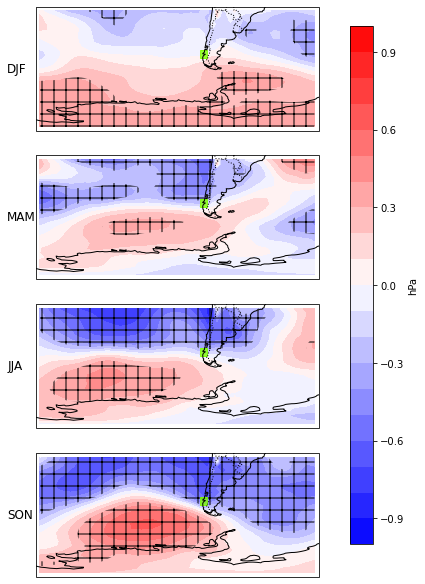

In [22]:
latS,latN,lonW,lonE,latlim,lonlim=dom.coord_domain(domain)
nrows=4
ncols=1
clevs=np.arange(-1.0,1.1,0.1)
#color='PiYG'
cmap='bwr'
exp='obs'
decomp='original'
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree()},figsize=(16,18))
axs=axs.flatten()
#Loop over all of the models
for i in np.arange(0,len(rList),1):
        lat,lon=climb.latlon(rList[i])
        lons, lats = np.meshgrid(rList[i][lon],rList[i][lat])
        # Contour plot
        CS1=axs[i].contourf(lons, lats, rList[i],clevs,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap)
        levels=[0,0.1,1.0]
        cs = axs[i].contourf(lons,lats,pList[i][:,:], transform=ccrs.PlateCarree(),levels=levels,
                hatches=["+", ""], alpha=0.)
        # Title each subplot with the name of the model
        axs[i].text(-0.1, 0.5, seasons[i],
        verticalalignment='center', horizontalalignment='left',
        transform=axs[i].transAxes,
        color='black', fontsize=12)
        geom = geometry.box(minx=-77,maxx=-73,miny=-44.7,maxy=-49.3)
        axs[i].add_geometries([geom], facecolor='chartreuse',edgecolor='chartreuse',crs=ccrs.PlateCarree(), alpha=0.8)
        # Draw the coastines for each subplot
        axs[i].coastlines()
        axs[i].add_feature(cfeature.BORDERS, linestyle=':', alpha=1)
        axs[i].add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='none'))
        axs[i].set_extent([lonW, lonE, latS,latN])
        #axs[i].set_extent([-90, -60, -56,-40])
    # Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.20, top=0.64, left=0.25, right=0.75,
                    wspace=0.0000000005, hspace=0.20)

#plt.tight_layout()
#cax=fig.add_axes([left,bottom,width,height]
#cbar_ax = fig.add_axes([0.2, 0.15, 0.6, 0.02])
#cbar=fig.colorbar(CS1,cax=cbar_ax,orientation='horizontal',label='%s'%(units))
cbar_ax = fig.add_axes([0.65, 0.225, 0.02, 0.4])
cbar=fig.colorbar(CS1,cax=cbar_ax,orientation='vertical',label='%s'%(units))
#plt.suptitle('%s'%(plotname))



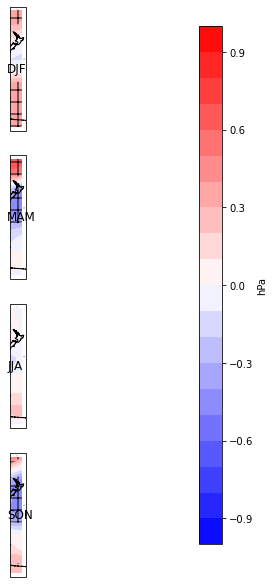

In [17]:
latS,latN,lonW,lonE,latlim,lonlim=dom.coord_domain(domain)
nrows=4
ncols=1
clevs=np.arange(-1.0,1.1,0.1)
#color='PiYG'
cmap='bwr'
exp='obs'
decomp='original'
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree()},figsize=(16,18))
axs=axs.flatten()
#Loop over all of the models
for i in np.arange(0,len(rList),1):
        lat,lon=climb.latlon(rList[i])
        lons, lats = np.meshgrid(rList[i][lon],rList[i][lat])
        # Contour plot
        CS1=axs[i].contourf(lons, lats, rList[i],clevs,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap)
        levels=[0,0.1,1.0]
        cs = axs[i].contourf(lons,lats,pList[i][:,:], transform=ccrs.PlateCarree(),levels=levels,
                hatches=["+", ""], alpha=0.)
        # Title each subplot with the name of the model
        axs[i].text(-0.1, 0.5, seasons[i],
        verticalalignment='center', horizontalalignment='left',
        transform=axs[i].transAxes,
        color='black', fontsize=12)
        geom = geometry.box(minx=-77,maxx=-73,miny=-44.7,maxy=-49.3)
        axs[i].add_geometries([geom], facecolor='None',edgecolor='chartreuse',crs=ccrs.PlateCarree(),linewidth=2, alpha=1.0)
        # Draw the coastines for each subplot
        axs[i].coastlines()
        axs[i].add_feature(cfeature.BORDERS, linestyle=':', alpha=1)
        axs[i].add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='none'))
        axs[i].set_extent([lonW, lonE, latS,latN])
        #axs[i].set_extent([-90, -60, -56,-40])
    # Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.20, top=0.64, left=0.25, right=0.75,
                    wspace=0.0000000005, hspace=0.20)

#plt.tight_layout()
#cax=fig.add_axes([left,bottom,width,height]
#cbar_ax = fig.add_axes([0.2, 0.15, 0.6, 0.02])
#cbar=fig.colorbar(CS1,cax=cbar_ax,orientation='horizontal',label='%s'%(units))
cbar_ax = fig.add_axes([0.65, 0.225, 0.02, 0.4])
cbar=fig.colorbar(CS1,cax=cbar_ax,orientation='vertical',label='%s'%(units))
#plt.suptitle('%s'%(plotname))


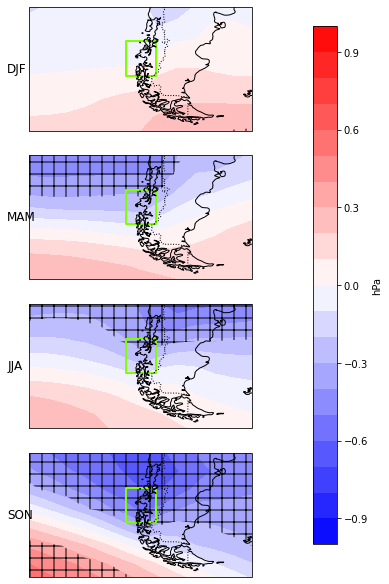

In [18]:
latS,latN,lonW,lonE,latlim,lonlim=dom.coord_domain(domain)
nrows=4
ncols=1
clevs=np.arange(-1.0,1.1,0.1)
#color='PiYG'
cmap='bwr'
exp='obs'
decomp='original'
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree()},figsize=(16,18))
axs=axs.flatten()
#Loop over all of the models
for i in np.arange(0,len(rList),1):
        lat,lon=climb.latlon(rList[i])
        lons, lats = np.meshgrid(rList[i][lon],rList[i][lat])
        # Contour plot
        CS1=axs[i].contourf(lons, lats, rList[i],clevs,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap)
        levels=[0,0.1,1.0]
        cs = axs[i].contourf(lons,lats,pList[i][:,:], transform=ccrs.PlateCarree(),levels=levels,
                hatches=["+", ""], alpha=0.)
        # Title each subplot with the name of the model
        axs[i].text(-0.1, 0.5, seasons[i],
        verticalalignment='center', horizontalalignment='left',
        transform=axs[i].transAxes,
        color='black', fontsize=12)
        geom = geometry.box(minx=-77,maxx=-73,miny=-44.7,maxy=-49.3)
        axs[i].add_geometries([geom], facecolor='None',edgecolor='chartreuse',crs=ccrs.PlateCarree(),linewidth=2, alpha=1.0)
        # Draw the coastines for each subplot
        axs[i].coastlines()
        axs[i].add_feature(cfeature.BORDERS, linestyle=':', alpha=1)
        axs[i].add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='none'))
        #axs[i].set_extent([lonW, lonE, latS,latN])
        axs[i].set_extent([-90, -60, -56,-40])
    # Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.20, top=0.64, left=0.25, right=0.75,
                    wspace=0.0000000005, hspace=0.20)

#plt.tight_layout()
#cax=fig.add_axes([left,bottom,width,height]
#cbar_ax = fig.add_axes([0.2, 0.15, 0.6, 0.02])
#cbar=fig.colorbar(CS1,cax=cbar_ax,orientation='horizontal',label='%s'%(units))
cbar_ax = fig.add_axes([0.65, 0.225, 0.02, 0.4])
cbar=fig.colorbar(CS1,cax=cbar_ax,orientation='vertical',label='%s'%(units))
#plt.suptitle('%s'%(plotname))


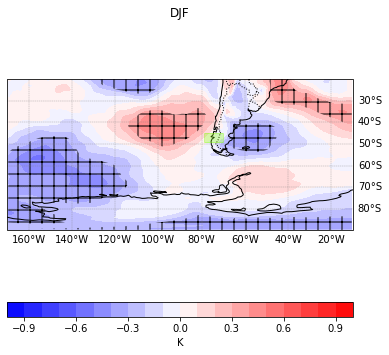

In [45]:

#------------------------------------
clevsT=np.arange(-1.0,1.1,0.1)
#color='PiYG'
color='bwr'
exp='obs'
decomp='original'
i=0
lat,lon=climb.latlon(rList[i])
#figtrend=myplot.oneplot_rvalue(variable=variable, decomp=decomp, exp=exp, model=model, clevs=clevsT, units=units, subdomain=subdomain, par=par, xlon=par[0][lon], ylat=par[0][lat], season=season, iyr=iyr, fyr=fyr,extent=mapa)

latS,latN,lonW,lonE,latlim,lonlim=dom.coord_domain(subdomain)
fig,axs= plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(8,10))

lons, lats = np.meshgrid(rList[i][lon],par[i][lat])

CS1=axs.contourf(lons,lats, rList[i][:,:],clevsT,
                transform=ccrs.PlateCarree(),
                cmap=color,extent='both')
levels=[0,0.1,1.0]
cs = axs.contourf(lons,lats,pList[i][:,:], transform=ccrs.PlateCarree(),levels=levels,
                hatches=["+", ""], alpha=0.)
    # Draw the coastines for each subplot
axs.coastlines()
axs.add_feature(cfeature.BORDERS, linestyle=':', alpha=1)
    #axs.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='None', facecolor='None'))
axs.set_extent([lonW, lonE, latS,latN])
        # Longitude and latitude labels
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.4, color='grey', alpha=0.8, linestyle='--')
gl.top_labels = False
gl.left_labels = False
gl.xlines = True
gl.ylines = True
#gl.xlocator = mticker.FixedLocator([-180,-10])
#gl.ylocator = mticker.FixedLocator([-20,-90])
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
#gl.xlim(80, 120)
#gl.xlabel_style = {'size': 15, 'color': 'gray'}
#gl.xlabel_style = {'color': 'red', 'weight': 'bold'}
    # Adjust the location of the subplots on the page to make room for the colorbar
geom = geometry.box(minx=-79,maxx=-70,miny=-44.7,maxy=-49.3)
axs.add_geometries([geom], facecolor='chartreuse',edgecolor='chartreuse',crs=ccrs.PlateCarree(), alpha=0.3)
fig.subplots_adjust(bottom=0.35, top=0.7, left=0.20, right=0.80,
                    wspace=0.05, hspace=0.5)
    # Add a colorbar axis at the bottom of the graph
    #([xmin,ymin,dx,dy])
cbar_ax = fig.add_axes([0.2, 0.3, 0.6, 0.02])
    # Draw the colorbar
cbar=fig.colorbar(CS1, cax=cbar_ax,orientation='horizontal',label='%s'%(units))
    ## Add a big title at the top
plt.suptitle('%s'%(seasons[i]),y=0.73)

plt.show()